# Requirements
** Client Requirement**
* Hello, I am contacting you because I have to submit an assignment related to time series forecasting, however I have not been trained on this subject and therefore encounter difficulties. Could you help me in the realization of this duty while explaining me the reasoning step by step, so that I am able to understand?

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# change the directory
%cd /content/drive/MyDrive/7-Colab-workspace/18-ARIMAProject_Detailed



/content/drive/MyDrive/7-Colab-workspace/18-ARIMAProject_Detailed


In [105]:
ls

arima_main_version_01.html  arima_main_version_01.ipynb  Datasets_cac40.csv


In [106]:
import pandas as pd
import numpy as np
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

# Create subplots with one trace per page using go object of plotly.graph_objs module 
import plotly.graph_objs as go

# Import TimeSeries class from darts library
try:
    from darts import TimeSeries
except ImportError:
    !pip install darts
    from darts import TimeSeries

import matplotlib.pyplot as plt


# Helping Functions

In [107]:
def plot(df,x_feature_name,y_feature_name,title):
    """
    This function takes two dataframes as input and plots the number of calls per day and per week.

    Args:
    daily_df (pandas.DataFrame): A dataframe containing daily call data.
    weekly_df (pandas.DataFrame): A dataframe containing weekly call data.

    Returns:
    None
    """

    # Create a subplot with two rows and one column
    # fig = make_subplots(rows=2, cols=1)
    fig = go.Figure()
    # Add a trace for daily calls
    fig.add_trace(
        go.Scatter(
            x=df[x_feature_name],
            y=df[y_feature_name],
            name=y_feature_name,
            mode='lines+markers'
        ))

 

    # Update xaxis properties
    fig.update_xaxes(title_text='Date')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature_name)

    # Update title and height
    fig.update_layout(
        title=f'{title}',
        height=500,
        width=1200
    )

    # Show the plot
    fig.show()

    # Write the plot to an HTML file
    # fig.write_html(f'Visualization/btc.html')


def train_test_predicted_plot(df_train,
                              df_test,
                              x_feature ,
                              y_feature,
                              predicted, 
                              model_name):
    """
    Plots the training data, actual values, and forecasted values using Plotly.

    Args:
        train (pd.Series): The training data.
        test (pd.Series): The actual values.
        predicted (pd.Series): The forecasted values.
        model_name (str): The name of the forecasting model.

    Returns:
        None
    """
  

   
    # Create a subplot with two rows and one column
    fig = go.Figure()

    fig.add_trace(
    go.Scatter(
        x=df_train[x_feature],
        y=df_train[y_feature],
        name='Training Data',
        mode='lines+markers'
    ))

    # Add a trace for actual values
    fig.add_trace(
        go.Scatter(
            x=df_test[x_feature],
            y=df_test[y_feature],
            name='Actual Values',
            mode='lines+markers'
        )
    )

    # Add a trace for forecasted values
    fig.add_trace(
        go.Scatter(
            x=df_test[x_feature],
            y=forecast[y_feature],
            name=f'{model_name}',
            mode='lines+markers'
        )
    )

    # Update xaxis properties
    fig.update_xaxes(title_text='Time')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature)

    # Update title and height
    fig.update_layout(
        title=f'Forecasting using {model_name}',
        height=500,
        width=1500
    )

    # Save the plot as an HTML file
    fig.show()
    # fig.write_html(f'Visualization/forecasting_using_{model_name}'+'.html')
    # fig.write_image(f'Visualization/forecasting_using_{model_name}'+'.png')


# Datasets Meta information

## Data Head

In [108]:
df = pd.read_csv('Datasets_cac40.csv')

# # Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'],utc=True)


# Change the date format using dt.strftime()
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

df.head()

,Date,Adj Close
0,2012-01-02,3245.399902
1,2012-01-03,3193.649902
2,2012-01-04,3144.909912
3,2012-01-05,3137.360107
4,2012-01-08,3127.689941


## Data Tail

In [109]:
df.tail()

,Date,Adj Close
2807,2022-12-22,6504.899902
2808,2022-12-26,6550.660156
2809,2022-12-27,6510.490234
2810,2022-12-28,6573.470215
2811,2022-12-29,6473.759766


## Meta information 
* Size of the Datasets
* Mean of Adj Close
* Median of Adj Close
* STD of Adj Close
* and other statistical tools

In [110]:
df.describe()

,Adj Close
count,2812.000000
mean,4980.756192
std,956.380996
min,2950.469971
25%,4323.115112
50%,4973.794922
75%,5527.652344
max,7376.370117


# Box-Jenkins Framework
The **Box-Jenkins** method is a statistical technique used for time series analysis and forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an **ARMA model** if it is stationary or an **ARIMA model** if it is non-stationary.

The **Box-Jenkins** method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series2. The model can analyze several different types of time series data for forecasting purposes3.

## ARIMA Model Pipeline
**Autoregressive Integrated Moving Average** (ARIMA) Model
* autoregressive models: AR(p)
* moving average models: MA(q)
* mixed autoregressive moving average models: ARMA(p, q)
* integration models: ARIMA(p, d, q)

## Stationary Test
* **What is stationary Data ?**    
Stationary data refers to time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.
* **Why we need stationary Data for ARIMA Model**  
ARIMA models rely on the assumption that the time series being modeled is stationary. Therefore that assumption needs to hold if you want to use these models. The ARIMA model uses differenced data to make the data stationary, which means there’s a consistency of the data over time. This function removes the effect of trends or seasonality, such as market or economic data. We make the data stationary only in case of ARIMA because the ARIMA model looks at the past data to predict future values.

In [111]:
def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")



In [112]:
# apply adfuller test for check the stationary of the data
# let's check the whether the data is stationary or not 
adfuller_test(df['Adj Close'])

ADF Test Statistic : -1.7743299494170925
p-value : 0.3932785572706652
#Lags Used : 0
Number of Observations Used : 2811
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


## Checking the status of data whether now stationary data or not after differencing

In [113]:
df['Adj_Close_First_Difference']=df['Adj Close']-df['Adj Close'].shift(1)

# apply adfuller test for check the stationary of the data
# let's check the whether the data is stationary or not 
adfuller_test(df['Adj_Close_First_Difference'].iloc[1:])



ADF Test Statistic : -10.29812987972646
p-value : 3.4281445049633608e-18
#Lags Used : 28
Number of Observations Used : 2782
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [114]:
# lets see the visualization of orignal value Adj Close
plot(df,'Date','Adj Close','Adj Close Value Orignal')

In [115]:
# lets see the visualization of Adj Close after differnce from its previosu value
# now we can observe all the value are look like stationary data(mean,varience close to zero or around to zero) 
plot(df,'Date','Adj_Close_First_Difference','Adj Close Value After 1 Difference')

##ARIMA Model fitting

### split the data into train and validation data

In [116]:
# converting dataframe to time series object to make the data to fit the model 
time_series_hourly = TimeSeries.from_dataframe(df,'Date','Adj Close',freq='D' ,fill_missing_dates=True,fillna_value=True)


# splting the datsets 98% for training the mode and 2% for testing the model
train , test = time_series_hourly.split_after(0.98)

# print the shape of train and test data
print('Shape of train set : ',train.pd_dataframe().shape)
print('Shape of test set : ',test.pd_dataframe().shape)
Horizan = test.pd_dataframe().shape[0]

Shape of train set :  (3934, 1)
Shape of test set :  (81, 1)


### Inspect Seasonality

In [117]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(time_series_hourly, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


### Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the MA component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

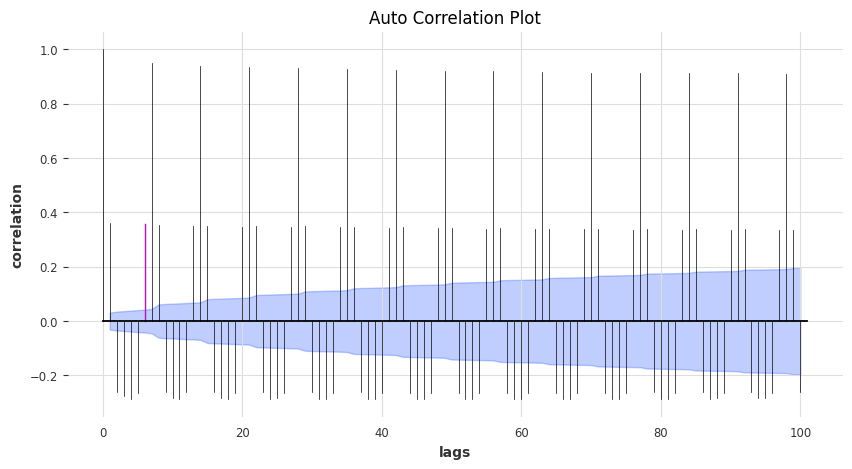

In [118]:
from darts.utils.statistics import plot_acf,plot_pacf


plot_acf(time_series_hourly, m=6, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)
plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Auto Correlation Plot')
plt.show()

### Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the AR component of the ARIMA model.

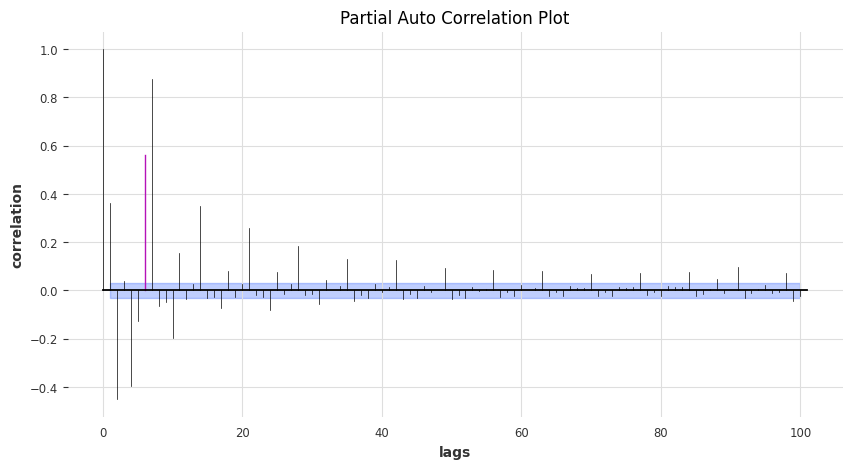

In [119]:
from darts.utils.statistics import plot_acf,plot_pacf
plot_pacf(time_series_hourly, m=6, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Partial Auto Correlation Plot')
plt.show()

In [120]:
from darts.models.forecasting.arima import ARIMA

arima_model =  ARIMA(p= 6 , #, for Auto regressive parameter
                     d=1  , # for difference to make the data is statioanry
                     q = 6 ,  # for the moving Average,
                     seasonal_order=(0, 0, 0, 7)
                     )
arima_model.fit(train)


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(p=6, d=1, q=6, seasonal_order=(0, 0, 0, 7), trend=None, random_state=0, add_encoders=None)

In [121]:
predictions = arima_model.predict(Horizan)

In [122]:
# Convert train_series into a pandas dataframe and reset index
df_train = train.pd_dataframe().reset_index()

# Convert test_series into a pandas dataframe and reset index
df_test = test.pd_dataframe().reset_index()

# Convert prediction into a pandas dataframe and reset index
forecast = predictions.pd_dataframe().reset_index()


x_feature ='Date' 
y_feature='Adj Close'
model_name = 'Arima Prediction'
train_test_predicted_plot(df_train,df_test,x_feature,y_feature,forecast,'ARTIMA-Prediction')


In [124]:
%%shell
jupyter nbconvert --to html  arima_main_version_01.ipynb

[NbConvertApp] Converting notebook arima_main_version_01.ipynb to html
[NbConvertApp] Writing 1028654 bytes to arima_main_version_01.html


In [127]:
# %%shell
# jupyter nbconvert --to webpdf  arima_main_version_01.ipynb